In [1]:
!pip install imbalanced-learn

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans


In [3]:
url = "https://raw.githubusercontent.com/AnjulaMehto/Sampling_Assignment/main/Creditcard_data.csv"
df = pd.read_csv(url)

df.head()


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,1
2,1,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [2]:
df['Class'].value_counts()


,count
Class,
0,763
1,9


In [21]:
from imblearn.over_sampling import SMOTE

X = df.drop('Class', axis=1)
y = df['Class']

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

balanced_df = pd.concat([X_resampled, y_resampled], axis=1)

balanced_df['Class'].value_counts()


,count
Class,
0,763
1,763


In [22]:
#Random Sampling
sample1 = balanced_df.sample(frac=0.8, random_state=1)

In [23]:
#Stratified Sampling
sample2, _ = train_test_split(
    balanced_df,
    test_size=0.2,
    stratify=balanced_df['Class'],
    random_state=2
)

In [24]:
#Systematic Sampling
sample3 = balanced_df.iloc[::2, :]

In [25]:
#Cluster sampling
X_cluster = balanced_df.drop('Class', axis=1)

scaler_cluster = StandardScaler()
X_scaled = scaler_cluster.fit_transform(X_cluster)

kmeans = KMeans(n_clusters=5, random_state=42)
balanced_df['Cluster'] = kmeans.fit_predict(X_scaled)

selected_clusters = np.random.choice(
    balanced_df['Cluster'].unique(),
    size=2,
    replace=False
)

sample4 = balanced_df[
    balanced_df['Cluster'].isin(selected_clusters)
].drop('Cluster', axis=1)


In [26]:
#Bootstrap sampling
sample5 = balanced_df.sample(frac=0.8, replace=True, random_state=4)

In [27]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "SVM": SVC(),
    "KNN": KNeighborsClassifier()
}

In [28]:
def evaluate_model(sample, model):
    X = sample.drop('Class', axis=1)
    y = sample['Class']

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42
    )

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    return accuracy_score(y_test, preds) * 100


In [29]:
samples = {
    "Random": sample1,
    "Stratified": sample2,
    "Systematic": sample3,
    "Cluster": sample4,
    "Bootstrap": sample5
}

results = {}

for m_name, model in models.items():
    results[m_name] = {}
    for s_name, sample in samples.items():
        acc = evaluate_model(sample, model)
        results[m_name][s_name] = round(acc, 2)

result_df = pd.DataFrame(results).T
result_df


,Random,Stratified,Systematic,Cluster,Bootstrap
Logistic Regression,93.73,92.08,91.27,98.18,90.19
Decision Tree,97.00,97.54,94.76,99.09,97.28
Random Forest,99.18,99.73,99.13,99.09,99.18
SVM,97.55,97.81,98.69,100.00,96.73
KNN,92.92,93.17,90.39,92.73,91.83


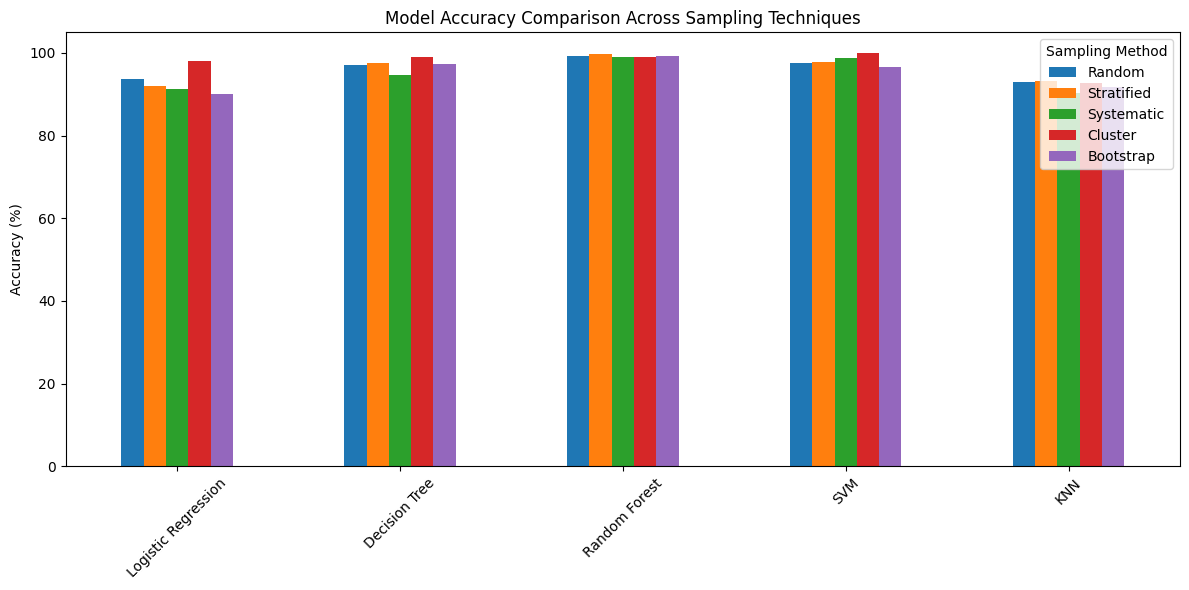

In [34]:
result_df.plot(kind='bar', figsize=(12,6))
plt.title("Model Accuracy Comparison Across Sampling Techniques")
plt.ylabel("Accuracy (%)")
plt.xticks(rotation=45)
plt.legend(title="Sampling Method")
plt.savefig("accuracy_barplt.png")
plt.tight_layout()
plt.show()

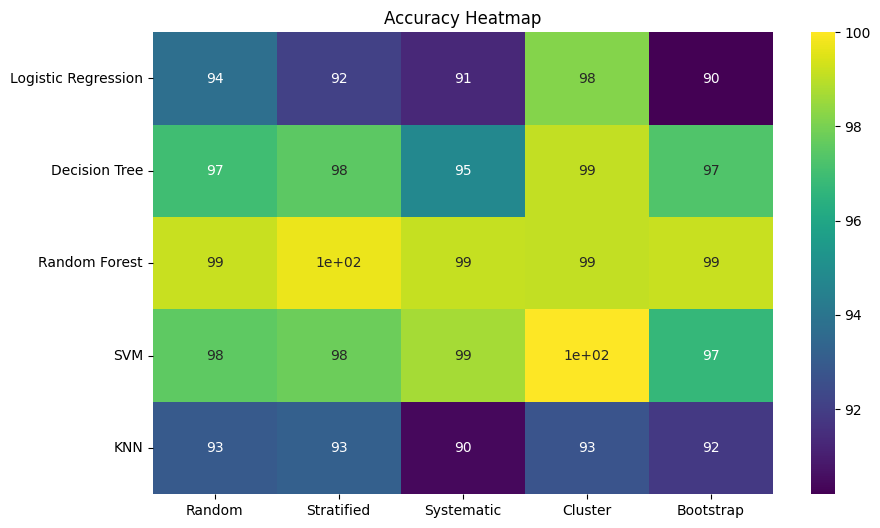

In [31]:
plt.figure(figsize=(10,6))
sns.heatmap(result_df, annot=True, cmap="viridis")
plt.title("Accuracy Heatmap")
plt.show()


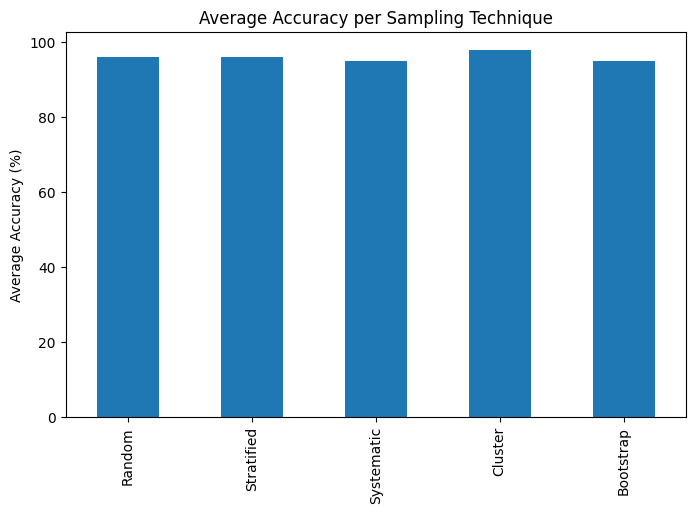

In [35]:
avg_scores = result_df.mean(axis=0)

avg_scores.plot(kind='bar', figsize=(8,5))
plt.title("Average Accuracy per Sampling Technique")
plt.ylabel("Average Accuracy (%)")
plt.savefig("avg_sampling_accuracy.png")
plt.show()


In [33]:
result_df = pd.DataFrame(results).T
result_df


,Random,Stratified,Systematic,Cluster,Bootstrap
Logistic Regression,93.73,92.08,91.27,98.18,90.19
Decision Tree,97.00,97.54,94.76,99.09,97.28
Random Forest,99.18,99.73,99.13,99.09,99.18
SVM,97.55,97.81,98.69,100.00,96.73
KNN,92.92,93.17,90.39,92.73,91.83
